In [5]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
import math

In [6]:
fontlabel = 16

lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수

resolution = 50        # 시뮬레이션 해상도
design_region_resolution = 50

# nfreq = 50             # 추출할 주파수 개수
df = fmax-fmin         # 주파수 대역폭

# df = 0    
nfreq = 1

In [7]:
SiO2 = mp.Medium(index=1.45)
TiO2 = mp.Medium(index=2.6)
Air = mp.Medium(index=1.0)

tpml = 0.4

boundary_layers = [
    mp.PML(tpml, direction=mp.Y),
    mp.PML(tpml, direction=mp.X)
]

tag_bot   = 0.5
tsio2     = 4
tag_side  = 4
design_region_height = 0.5
monitor_position     = 0.5 * 2
monitor_blank        = 0.5 * 0.1

width_ag       = 0.2
width_sio2     = 2
width_bot_ag   = round(width_ag + width_sio2 + width_ag, 2)
design_region_width  = round(width_bot_ag, 3)

Sx = 3
Sy = 3
cell_size   = mp.Vector3(Sx, Sy)

y_bottom = -Sy/2 + tpml
center_y_ag        = y_bottom + tag_bot/2
center_y_sio2      = y_bottom + tag_bot + tsio2/2
center_y_design    = y_bottom + tag_bot + tsio2 + design_region_height/2
center_y_monitor_position   = y_bottom + tag_bot + tsio2 + design_region_height + monitor_position
# center_y_source_position    = y_bottom + tag_bot + 5/fcen  # 예시
center_y_source_position    = y_bottom + tag_bot + 1/fcen  # 예시
center_Ag_x_offset = design_region_width/2 - width_ag/2

Nx = int(design_region_resolution * design_region_width) + 1
Ny = 1

geometry = [

]

In [8]:
num_sources = 1
spacing = 10 / resolution  

offsets = [ (i - (num_sources - 1) // 2) * spacing for i in range(num_sources) ]

sources = [
    mp.Source(
        mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True),
        component=mp.Ex,
        center=mp.Vector3(0, 0, 0)
    )
    for offset in offsets
]

k0 = mp.Vector3(0,0,0)

sims = [
    mp.Simulation(
        resolution=resolution,
        cell_size=cell_size,
        boundary_layers=boundary_layers,
        geometry=geometry,
        sources=[src], 
        default_material=mp.Medium(index=1),
        k_point=k0
    )
    for src in sources
]

In [9]:
inner_x = Sx - 2*tpml
inner_y = Sy - 2*tpml

# 모니터가 놓일 중심 좌표
y_off = 0.5 * inner_y     # y축 상·하단
x_off = 0.5 * inner_x     # x축 좌·우단

nearfield_box = sims[0].add_near2far(
    fcen, 0, 1,
    # y축 상단
    mp.Near2FarRegion(
        center=mp.Vector3(0, +y_off),
        size=mp.Vector3(inner_x, 0)
    ),
    # y축 하단
    mp.Near2FarRegion(
        center=mp.Vector3(0, -y_off),
        size=mp.Vector3(inner_x, 0),
        weight=-1
    ),
    # x축 우측
    mp.Near2FarRegion(
        center=mp.Vector3(+x_off, 0),
        size=mp.Vector3(0, inner_y)
    ),
    # x축 좌측
    mp.Near2FarRegion(
        center=mp.Vector3(-x_off, 0),
        size=mp.Vector3(0, inner_y),
        weight=-1
    )
)

<Axes: xlabel='X', ylabel='Y'>

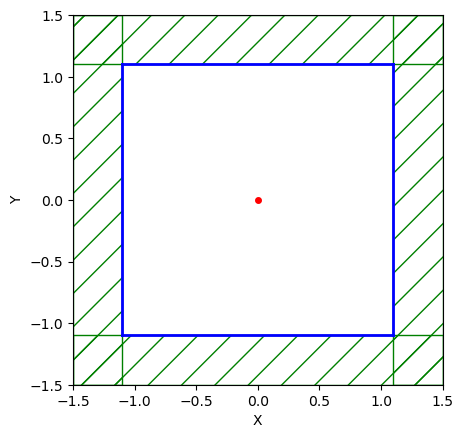

In [10]:
sims[0].plot2D()

In [11]:
sims[0].run(until=200)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000122786 s
Working in 2D dimensions.
Computational cell is 3 x 3 x 0 with resolution 50
time for set_epsilon = 0.0524912 s
-----------
Meep progress: 149.91/200.0 = 75.0% done in 4.0s, 1.3s to go
on time step 14991 (time=149.91), 0.000266911 s/step
run 0 finished at t = 200.0 (20000 timesteps)


In [20]:
r = 10

# resolution of far fields (points/μm)
res_ff = 1

far_flux_box = (nearfield_box.flux(mp.Y,
                                   mp.Volume(center=mp.Vector3(y=r),
                                             size=mp.Vector3(2*r)),
                                   res_ff)[0] -
                nearfield_box.flux(mp.Y,
                                   mp.Volume(center=mp.Vector3(y=-r),
                                             size=mp.Vector3(2*r)),
                                   res_ff)[0] +
                nearfield_box.flux(mp.X,
                                   mp.Volume(center=mp.Vector3(r),
                                             size=mp.Vector3(y=2*r)),
                                   res_ff)[0] -
                nearfield_box.flux(mp.X,
                                   mp.Volume(center=mp.Vector3(-r),
                                             size=mp.Vector3(y=2*r)),
                                   res_ff)[0])

In [21]:
npts = 360  # number of points in [0,2*pi) range of angles
angles = 2*math.pi/npts*np.arange(npts)

E = np.zeros((npts,3),dtype=np.complex128)
H = np.zeros((npts,3),dtype=np.complex128)
for n in range(npts):
    ff = sims[0].get_farfield(nearfield_box,
                          mp.Vector3(r*math.cos(angles[n]),
                                     r*math.sin(angles[n])))
    E[n,:] = [ff[j] for j in range(3)]
    H[n,:] = [ff[j+3] for j in range(3)]

Px = np.real(np.conj(E[:, 1]) * H[:, 2] - np.conj(E[:, 2]) * H[:, 1])
Py = np.real(np.conj(E[:, 2]) * H[:, 0] - np.conj(E[:, 0]) * H[:, 2])
Pr = np.sqrt(np.square(Px) + np.square(Py))

# integrate the radial flux over the circle circumference
far_flux_circle = np.sum(Pr)*2*np.pi*r/len(Pr)

print("flux:,  {:.6f}, {:.6f}".format(far_flux_box,far_flux_circle))

flux:,  0.349307, 0.338207


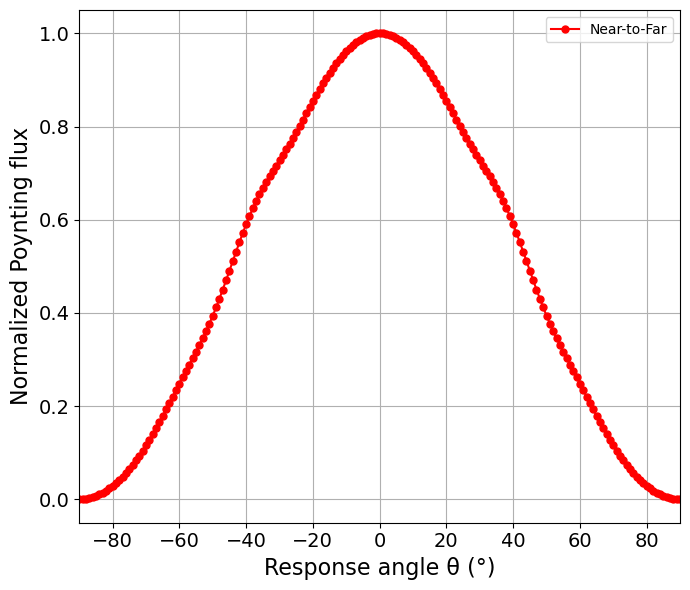

In [34]:
angles_deg = np.degrees(angles) -90

angle_min = -90
angle_max =  90

mask      = (angles_deg >= angle_min) & (angles_deg <= angle_max)
angles_sel = angles_deg[mask]
Pr_sel     = Pr[mask]

Pr_sel /= np.max(Pr_sel)

plt.figure(figsize=(7,6))
plt.plot(angles_sel, Pr_sel, 'ro-', markersize=5, label='Near-to-Far')
plt.xlim(angle_min, angle_max)
plt.xlabel("Response angle θ (°)", fontsize=16)
plt.ylabel("Normalized Poynting flux", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

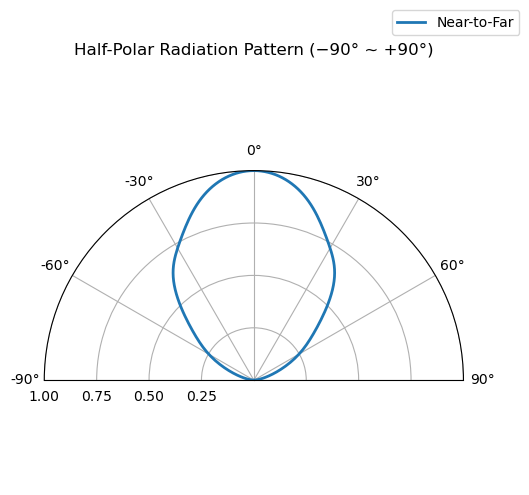

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# angles_sel: degrees in [-90, +90], Pr_sel: normalized [0,1]
theta = np.radians(angles_sel)   # polar plot은 라디안 필요
r = Pr_sel

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='polar')

# 0°를 위쪽(North)으로, 시계방향 증가 (원하면 제거/수정 가능)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

# 반원(−90° ~ +90°)만 보이도록 제한
ax.set_thetamin(-90)
ax.set_thetamax(90)

# 데이터 플롯
ax.plot(theta, r, linewidth=2, label='Near-to-Far')

# 반径 범위/라벨
ax.set_rlim(0, 1.0)
ax.set_rticks([0.25, 0.5, 0.75, 1.0])
ax.set_rlabel_position(90)   # 반径 라벨을 왼쪽(90°) 근처로 이동

ax.set_title('Half-Polar Radiation Pattern (−90° ~ +90°)', va='bottom')
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.15, 1.15))
plt.tight_layout()
plt.show()
